In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import lightgbm as lgb

In [104]:
df = pd.read_csv('weatherAUS.csv')

In [105]:
df.info(), df.describe(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

(None,
              MinTemp        MaxTemp       Rainfall   Evaporation  \
 count  143975.000000  144199.000000  142199.000000  82670.000000   
 mean       12.194034      23.221348       2.360918      5.468232   
 std         6.398495       7.119049       8.478060      4.193704   
 min        -8.500000      -4.800000       0.000000      0.000000   
 25%         7.600000      17.900000       0.000000      2.600000   
 50%        12.000000      22.600000       0.000000      4.800000   
 75%        16.900000      28.200000       0.800000      7.400000   
 max        33.900000      48.100000     371.000000    145.000000   
 
            Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
 count  75625.000000  135197.000000  143693.000000  142398.000000   
 mean       7.611178      40.035230      14.043426      18.662657   
 std        3.785483      13.607062       8.915375       8.809800   
 min        0.000000       6.000000       0.000000       0.000000   
 25%        4.800000     

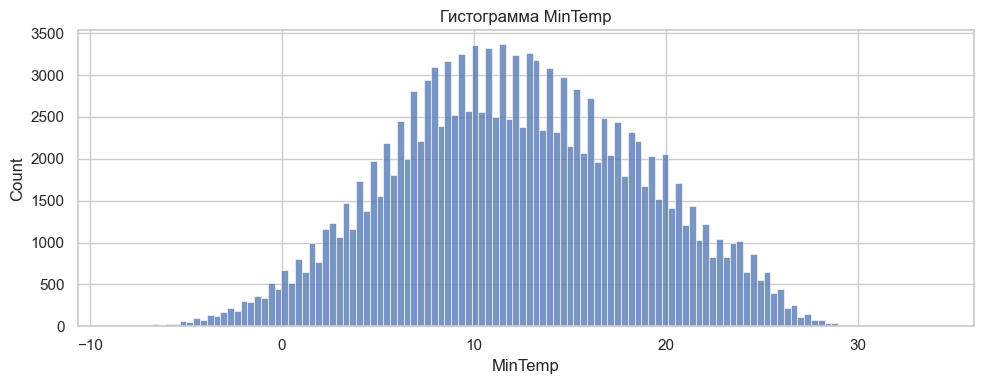

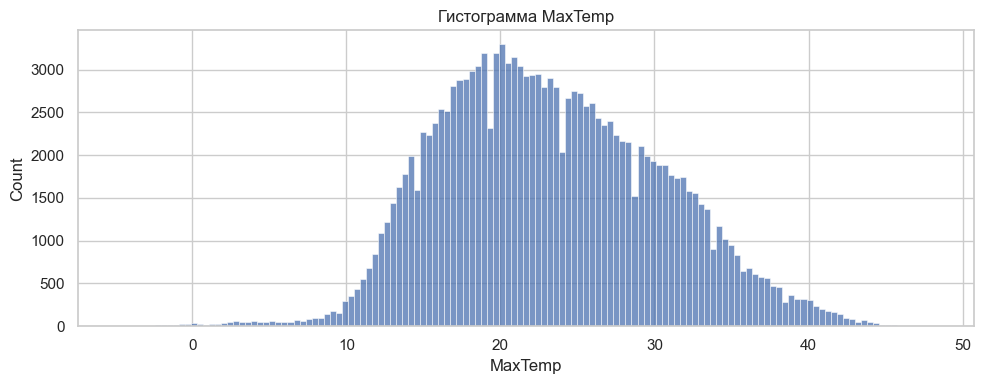

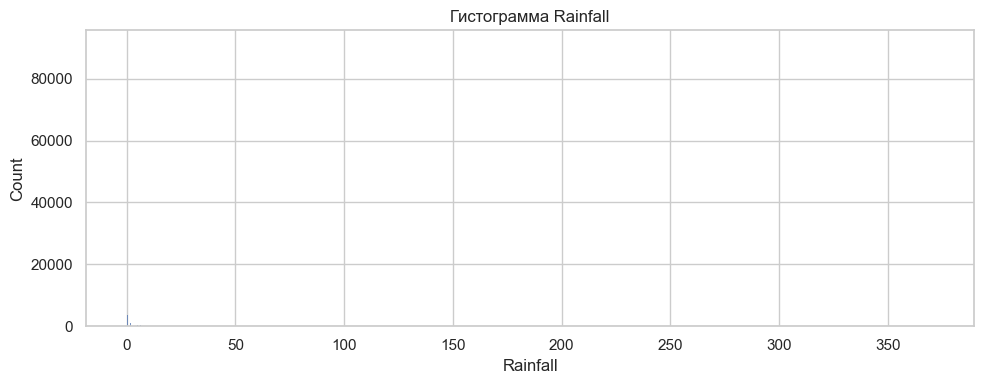

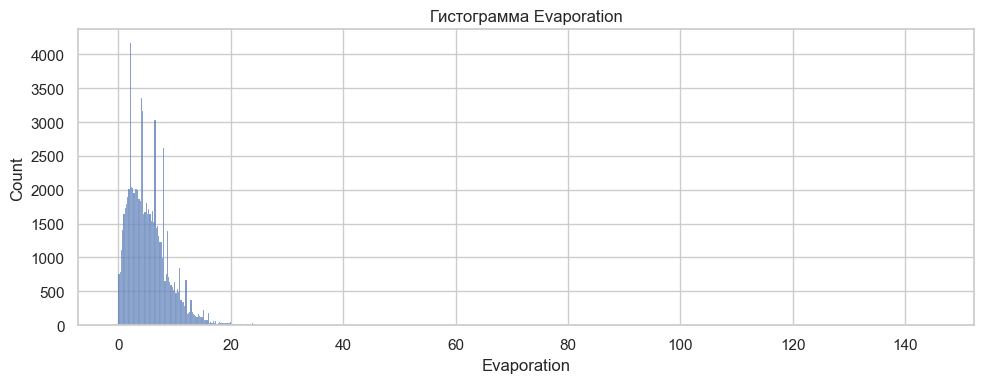

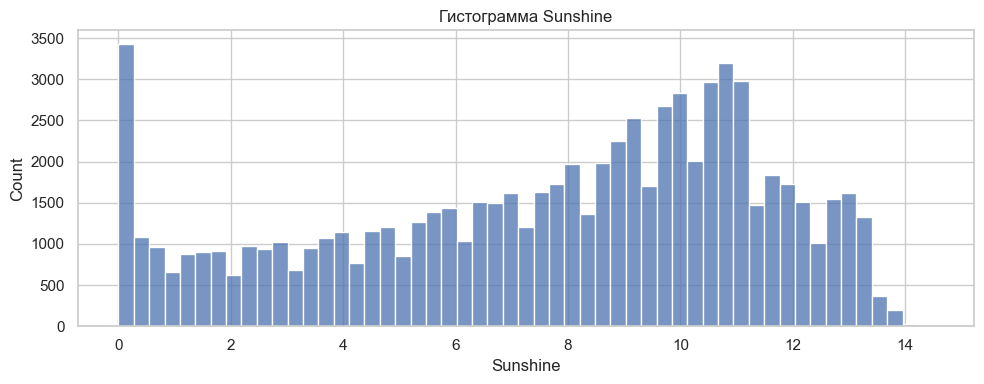

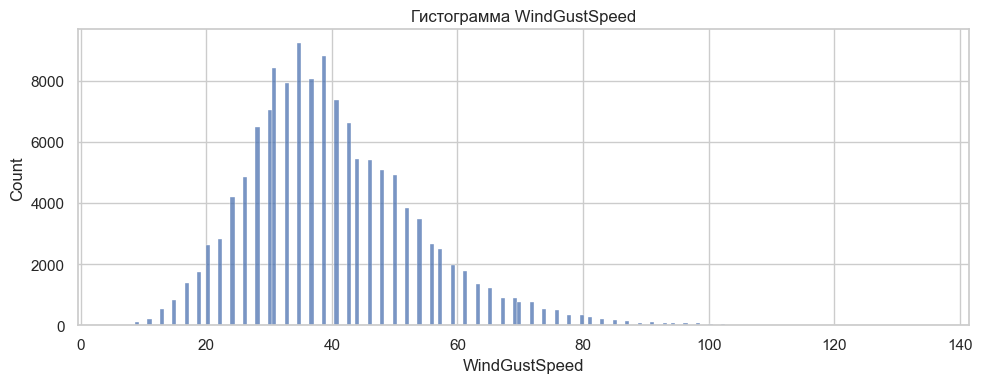

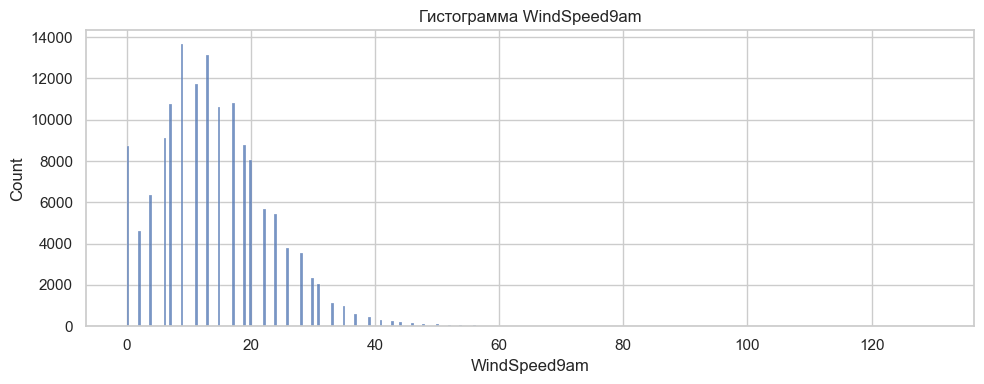

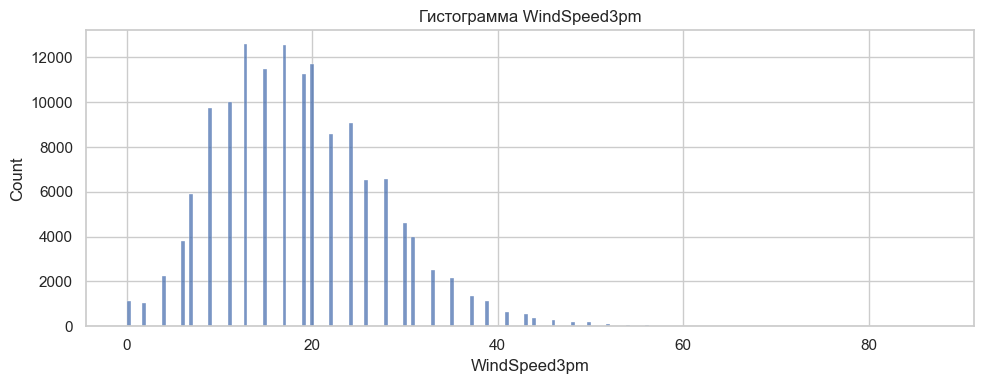

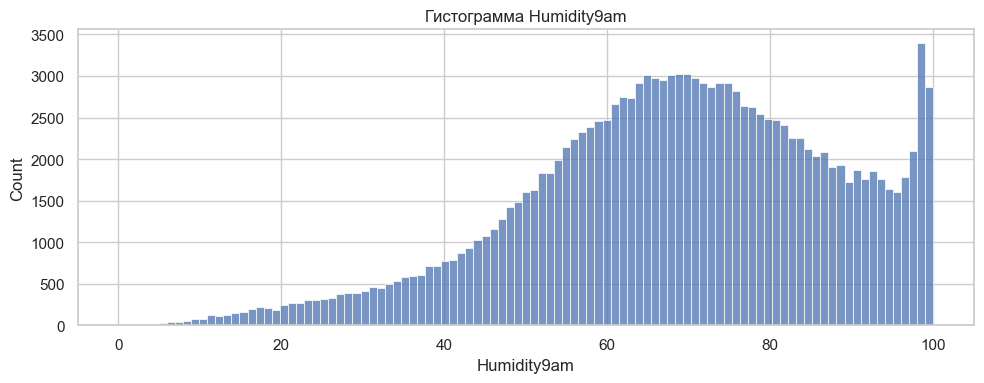

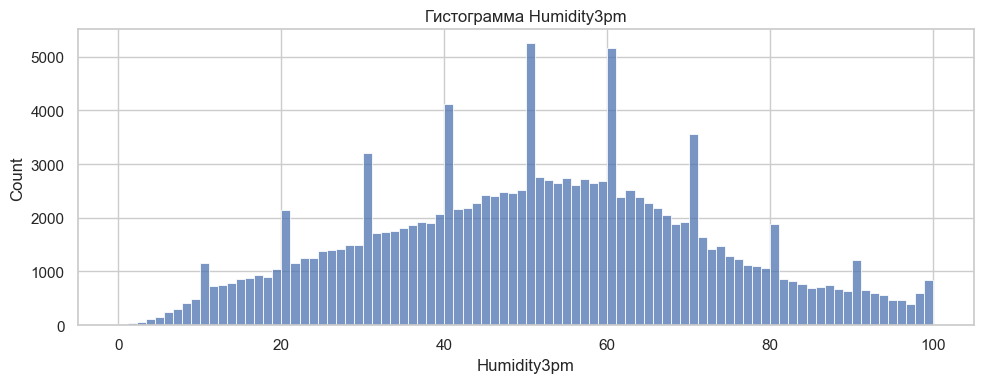

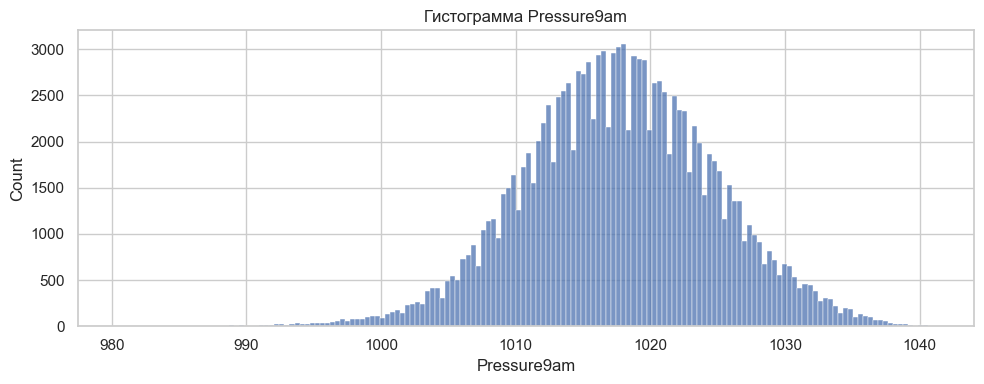

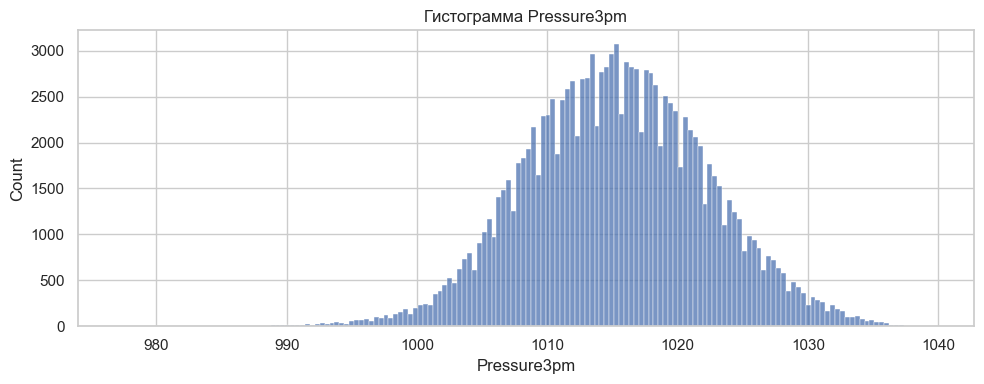

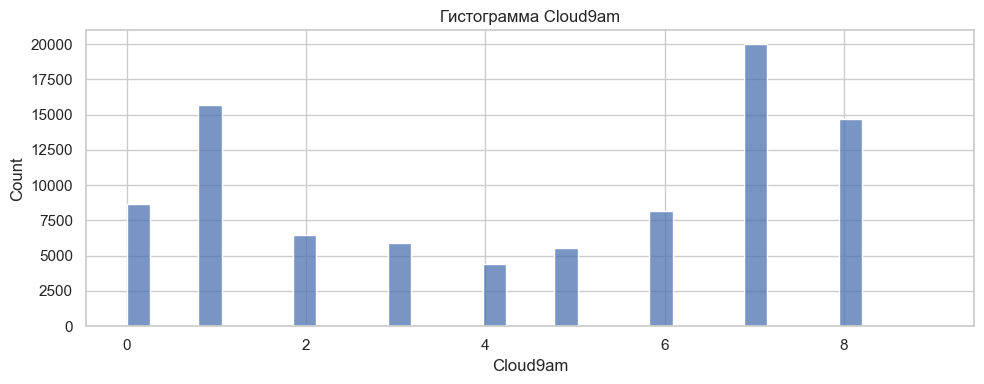

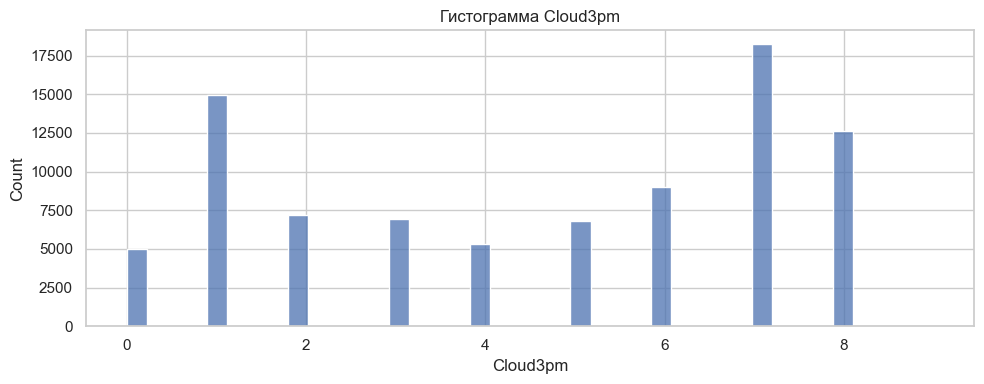

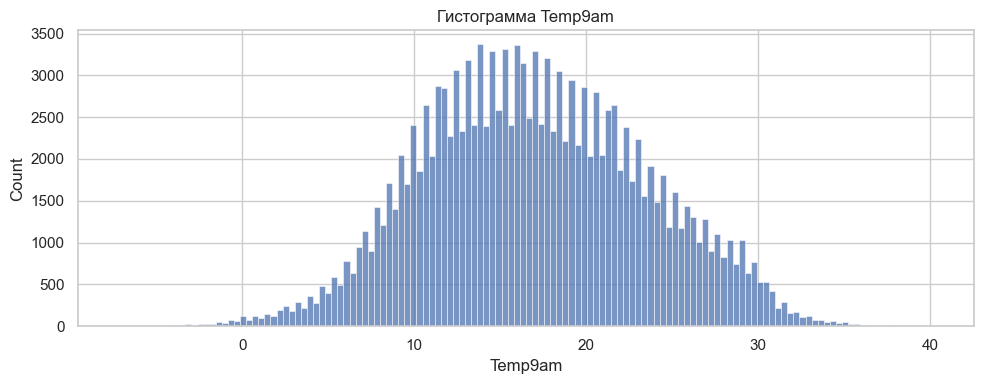

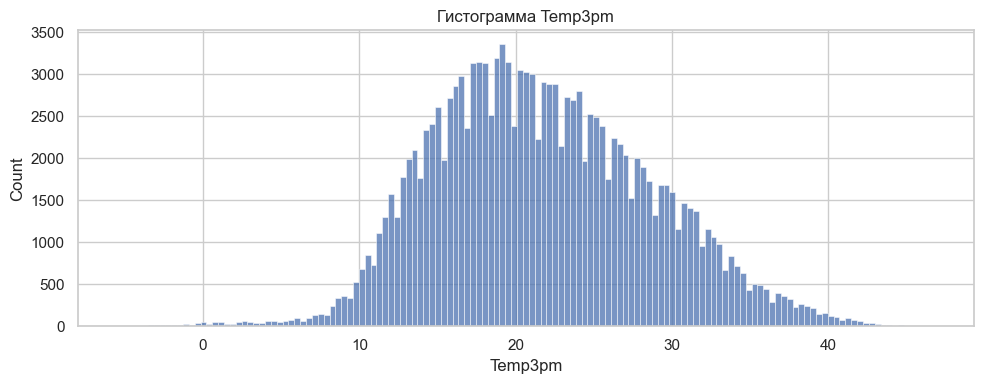

In [106]:
for column in df:
    if np.issubdtype(df[column].dtype, np.number):
        plt.figure(figsize=(10, 4))
        sns.histplot(df[column], kde=False)
        plt.title(f'Гистограмма {column}')
        
        plt.tight_layout()
        plt.show()

In [107]:
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [108]:
df.drop(labels=['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1, inplace=True)

In [109]:
columns_categorical = ['Location', 'WindGustDir', 
                       'WindDir9am', 'WindDir3pm', 'RainToday']
columns_float = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                 'Temp9am', 'Temp3pm']

numeric_imputer = SimpleImputer(strategy='mean')
df[columns_float] = numeric_imputer.fit_transform(df[columns_float])

categorical_imputer = SimpleImputer(strategy='most_frequent') 
df[columns_categorical] = categorical_imputer.fit_transform(df[columns_categorical])

In [110]:
df.dropna(subset=['RainTomorrow'], inplace=True)

In [111]:
for column in df.columns:
    if np.issubdtype(df[column].dtype, np.number):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        print(f"Выбросы {column}:\n", outliers.shape)
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

Выбросы MinTemp:
 (62, 19)
Выбросы MaxTemp:
 (478, 19)
Выбросы Rainfall:
 (26452, 19)
Выбросы WindGustSpeed:
 (3410, 19)
Выбросы WindSpeed9am:
 (545, 19)
Выбросы WindSpeed3pm:
 (1228, 19)
Выбросы Humidity9am:
 (1424, 19)
Выбросы Humidity3pm:
 (0, 19)
Выбросы Pressure9am:
 (1697, 19)
Выбросы Pressure3pm:
 (568, 19)
Выбросы Temp9am:
 (58, 19)
Выбросы Temp3pm:
 (288, 19)


In [112]:
for column in columns_categorical:
    if column != 'Date':
        for elem in df[column].unique():
            df[column + str(elem)] = df[column].isin([elem]).astype('int8')

df.drop(labels=columns_categorical, axis=1, inplace=True)
df.head()

C:\Users\diana\AppData\Local\Temp\ipykernel_13792\4055493621.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + str(elem)] = df[column].isin([elem]).astype('int8')


,Date,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,WindDir3pmSE,WindDir3pmN,WindDir3pmSW,WindDir3pmSSW,WindDir3pmS,WindDir3pmNNE,WindDir3pmNE,WindDir3pmENE,RainTodayNo,RainTodayYes
0,2008-12-01,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,...,0,0,0,0,0,0,0,0,1,0
1,2008-12-02,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,...,0,0,0,0,0,0,0,0,1,0
2,2008-12-03,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,...,0,0,0,0,0,0,0,0,1,0
3,2008-12-04,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,...,0,0,0,0,0,0,0,0,1,0
4,2008-12-05,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,...,0,0,0,0,0,0,0,0,1,0


In [113]:
df['RainTomorrow'] = df['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0)

In [114]:
for column in columns_float:
    mean = df[column].mean()
    std = df[column].std()
    df[column] = (df[column] - mean) / std
    
df.head()

,Date,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,WindDir3pmSE,WindDir3pmN,WindDir3pmSW,WindDir3pmSSW,WindDir3pmS,WindDir3pmNNE,WindDir3pmNE,WindDir3pmENE,RainTodayNo,RainTodayYes
0,2008-12-01,0.229326,-0.137291,1.150748,0.630920,0.909391,0.845575,0.231058,-1.395522,-1.849718,...,0,0,0,0,0,0,0,0,1,0
1,2008-12-02,-0.713333,0.190826,-0.392265,0.630920,-1.131327,0.582495,-1.300995,-1.237428,-1.355635,...,0,0,0,0,0,0,0,0,1,0
2,2008-12-03,0.150772,0.280312,-0.392265,0.823158,0.781846,1.108654,-1.641451,-0.973936,-1.866756,...,0,0,0,0,0,0,0,0,1,0
3,2008-12-04,-0.430535,0.623343,-0.392265,-1.291465,-0.238513,-1.127522,-1.244252,-1.711712,-0.163020,...,0,0,0,0,0,0,0,0,1,0
4,2008-12-05,0.873477,1.264661,2.179423,0.342562,-0.748693,0.319416,0.855227,-0.815841,-1.321560,...,0,0,0,0,0,0,0,0,1,0


In [115]:
df.to_csv('transformed_data.csv')

In [116]:
X = df.drop(labels=['Date', 'RainTomorrow'], axis=1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [118]:
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Точность Logistic Regression:", accuracy)

Точность Logistic Regression: 0.8738500731235552


In [119]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [120]:
model = LogisticRegression(solver='liblinear', max_iter=200, random_state=42)
acc_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))

print(f"Средняя точность Logistic Regression с KFold: {np.mean(acc_scores):.4f}")

Средняя точность Logistic Regression с KFold: 0.8755


In [95]:
model_SVC = SVC(kernel='linear', C=1.0, random_state=42)
model_SVC.fit(X_train, y_train)


y_pred_SVC = model_SVC.predict(X_test)
accuracy_SVC = accuracy_score(y_test, y_pred_SVC)
print(f"Точность модели SVM: {accuracy_SVC:.4f}")

Точность модели SVM: 0.8786


In [130]:
model_lgb = lgb.LGBMClassifier()

lgb_params = {
    'max_depth': range(16, 19),
    'num_leaves': range(34, 37),
    'min_child_samples': (17, 20)
}

grid = GridSearchCV(model_lgb, lgb_params, cv=5, n_jobs=4, verbose=True)
grid.fit(X_train, y_train)

model_lgb = lgb.LGBMClassifier(random_state=42, max_depth=grid.best_params_['max_depth'],
                         min_child_samples=grid.best_params_['min_child_samples'],
                         num_leaves=grid.best_params_['num_leaves'], n_estimators=1000,
                         objective='binary')

model_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


LGBMClassifier(max_depth=17, min_child_samples=17, n_estimators=1000,
               num_leaves=35, objective='binary', random_state=42)

In [131]:
y_pred_lgb = model_lgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lgb)

print(f"Точность LightGBM: {accuracy:.4f}")

Точность LightGBM: 0.8847
